In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import fiona
import seaborn as sns  
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from pysal.lib  import weights
from esda.moran import Moran, Moran_Local

from splot.esda import moran_scatterplot,lisa_cluster, plot_local_autocorrelation

### 축약한 변수들의 로지스틱 회귀분석(핫스팟)은  traffic, medical, landmark, population, store이 유의했다. 하지만 그 안의 세부적인 변수들에 대한 유의성도 알아보고자 전체 변수를 사용한 로지스틱 회귀분석(핫스팟)을 시행했다.  

## 사용할 데이터: fin_df_hot(핫스팟 포함한 데이터)

In [2]:
fin_df=gpd.read_file('fin_df_hot.geojson')

In [3]:
fin_df.columns

Index(['gid500', 'all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt', 'found_age_1', 'found_age_2', 'found_age_3', 'found_age_4',
       'found_age_5', 'found_age_6', 'runout_cnt', 'smbiz_yn_cnt',
       'rpr_per_gender_m', 'rpr_per_gender_f', 'rpr_per_age_bin_10',
       'rpr_per_age_bin_20', 'rpr_per_age_bin_30to50',
       'rpr_per_age_bin_50over', 'sme_loan_cnt', 'sme_loan_y_1',
       'sme_loan_y_2', 'sme_loan_y_3', 'sme_loan_y_4', 'sme_loan_y_5',
       'sme_loan_y_6', 'sales_est_amt_201703', 'sales_est_amt_201706',
       'sales_est_amt_201709', 'sales_est_amt_201712', 'sales_est_amt_201803',
       'sales_est_amt_201806', 'sales_est_amt_201809', 'sales_est_amt_201812',
       'sales_est_amt_201903', 'sales_est_amt_201906', 'sales_est_amt_201909',
       'sales_est_amt_201912', 'sales_est_amt_202003', 'sales_est_amt_202006',
       'sales_est_amt_202009', 'age10_ratio', 'age20_ratio', 'age30_ratio',
       'age40_ratio', 'age50_ratio', 'age60_ratio', 'age70_

In [5]:
#분석용 데이터프레임
final=fin_df[['gid500','geometry','all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt','cnt_market', 'cnt_busstop', 'cnt_subway', 'cnt_clinic', 'cnt_hospital',
       'cnt_element_s', 'cnt_middles_s', 'cnt_high_s', 'cnt_university',
       'cnt_landmark','y_매출액평균',
        'y_분기별매출액평균_03','y_분기별매출액평균_06','y_분기별매출액평균_09','y_분기별매출액평균_12',
    'y_연도별매출액평균_17','y_연도별매출액평균_18','y_연도별매출액평균_19','y_연도별매출액평균_20','hotspot']]

In [6]:
final.head()

,gid500,geometry,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적,ws_cnt,cnt_market,cnt_busstop,...,y_매출액평균,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20,hotspot
0,다바66a99a,"POLYGON ((127.11743 37.08901, 127.11741 37.093...",0.0,0.0,0.0,0.0,0.00,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,다바66a99b,"POLYGON ((127.11741 37.09352, 127.11738 37.098...",0.0,0.0,0.0,0.0,0.00,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,다바66b99a,"POLYGON ((127.12306 37.08903, 127.12303 37.093...",88.0,13.0,56.0,0.0,1781.97,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,다바66b99b,"POLYGON ((127.12303 37.09353, 127.12301 37.098...",0.0,0.0,0.0,0.0,182.80,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,다바67a99a,"POLYGON ((127.12868 37.08905, 127.12866 37.093...",0.0,0.0,0.0,0.0,0.00,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
a =final['cnt_market'] > 0
exist= final[a]
exist.describe()

,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적,ws_cnt,cnt_market,cnt_busstop,cnt_subway,cnt_clinic,...,y_매출액평균,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20,hotspot
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,848.609233,114.469909,608.206925,113.825227,21510.481088,17.137675,32.896125,1.970322,0.019786,0.791426,...,7128.746963,6687.581410,7236.233512,7210.527205,7464.611981,5968.670857,7206.146331,7907.442086,7534.055785,0.096455
std,1746.789598,248.789757,1260.991127,267.255926,40714.175680,55.012540,96.934111,2.603459,0.166316,3.793149,...,26055.939157,25126.947931,26126.351903,26166.517970,27143.590547,22288.281324,26490.979259,29122.593101,27149.706179,0.295336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,6.000000,0.000000,1810.760000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,67.000000,8.000000,40.000000,0.000000,4465.710000,0.000000,5.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,596.000000,77.000000,414.000000,55.000000,17989.890000,8.000000,20.000000,3.000000,0.000000,0.000000,...,2979.533333,2462.500000,3048.500000,3124.750000,3196.333333,2365.750000,2922.750000,3274.500000,3184.000000,0.000000
max,11734.000000,2135.000000,8472.000000,2182.000000,350462.070000,600.000000,1217.000000,18.000000,3.000000,46.000000,...,443717.800000,439361.250000,434969.500000,449432.000000,453572.000000,393261.000000,464547.750000,490119.000000,421352.000000,1.000000


## 로지스틱회귀분석(핫스팟)

In [8]:
x=exist[['all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt','cnt_market', 'cnt_busstop', 'cnt_subway', 'cnt_clinic', 'cnt_hospital',
       'cnt_element_s', 'cnt_middles_s', 'cnt_high_s', 'cnt_university',
       'cnt_landmark']]
y=exist['hotspot']

In [9]:
count_0 = len(exist[exist['hotspot']==0])
count_1 = len(exist[exist['hotspot']==1])
pct_of_1 = count_1/(count_0+count_1)
print("percentage of hotspot is", pct_of_1*100,"%")

percentage of hotspot is 9.64550700741962 %


In [10]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['hotspot'])

print("length of oversampled data is ",len(os_data_X))
print("Number of no hotspot in oversampled data",len(os_data_y[os_data_y['hotspot']==0]))
print("Number of hotspot",len(os_data_y[os_data_y['hotspot']==1]))
print("Proportion of no hotspot data in oversampled data is ",len(os_data_y[os_data_y['hotspot']==0])/len(os_data_X))
print("Proportion of hptspot data in oversampled data is ",len(os_data_y[os_data_y['hotspot']==1])/len(os_data_X))

length of oversampled data is  1746
Number of no hotspot in oversampled data 873
Number of hotspot 873
Proportion of no hotspot data in oversampled data is  0.5
Proportion of hptspot data in oversampled data is  0.5


In [11]:
x=exist[['all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt','cnt_market', 'cnt_busstop', 'cnt_subway', 'cnt_clinic', 'cnt_hospital',
       'cnt_element_s', 'cnt_middles_s', 'cnt_high_s', 'cnt_university',
       'cnt_landmark']]
y=exist['hotspot']

In [12]:
###RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


y=['hotspot']
X=['traffic_b', 'traffic_s', 'schools','university','medical','landmark', 'population_all',
       'population_adult', 'store_ws', 'store_mk']

logreg = LogisticRegression()
   
rfe = RFE(logreg, 16)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/opt/app-root/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
cols=['all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt','cnt_market', 'cnt_busstop', 'cnt_subway', 'cnt_clinic', 'cnt_hospital',
       'cnt_element_s', 'cnt_middles_s', 'cnt_high_s', 'cnt_university',
       'cnt_landmark']
X=os_data_X[cols]
y=os_data_y['hotspot']

In [14]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.332720
         Iterations: 35


/opt/app-root/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.520      
Dependent Variable:    hotspot            AIC:                1193.8599  
Date:                  2021-01-28 07:02   BIC:                1281.3012  
No. Observations:      1746               Log-Likelihood:     -580.93    
Df Model:              15                 LL-Null:            -1210.2    
Df Residuals:          1730               LLR p-value:        4.1808e-259
Converged:             0.0000             Scale:              1.0000     
No. Iterations:        35.0000                                           
-------------------------------------------------------------------------
                Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
all_cnt         -0.1283     0.0092 -13.9296 0.0000     -0.1463    -0.1102
old_cnt          0.1290     0.0092  13.9670 0.0000      0.1109     0

In [15]:
cols=['all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'cnt_market', 'cnt_subway', 'cnt_clinic', 
       'cnt_element_s','cnt_landmark']
X=os_data_X[cols]
y=os_data_y['hotspot']

In [16]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.340121
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.509      
Dependent Variable: hotspot          AIC:              1207.7027  
Date:               2021-01-28 07:04 BIC:              1262.3535  
No. Observations:   1746             Log-Likelihood:   -593.85    
Df Model:           9                LL-Null:          -1210.2    
Df Residuals:       1736             LLR p-value:      1.0216e-259
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
all_cnt           -0.1293   0.0086 -15.0576 0.0000 -0.1462 -0.1125
old_cnt            0.1299   0.0086  15.1216 0.0000  0

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/app-root/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [18]:
y_pred = logreg.predict(X_test)
print('test set에 대한 분류기 정확도: {:.2f}'.format(logreg.score(X_test, y_test)))

test set에 대한 분류기 정확도: 0.80


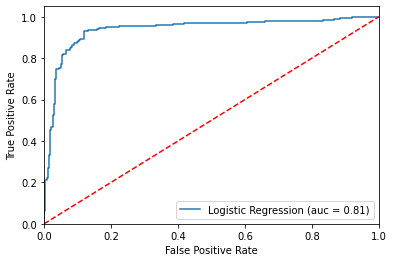

In [21]:
##ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('Log_ROC')
plt.show()

##로지스틱(핫스팟) : 'all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적', 'cnt_market', 'cnt_subway', 'cnt_clinic', cnt_element_s','cnt_landmark'

LLR p-value:1.0216e-259.  예측력: 0.81

In [23]:
np.exp(result.params)#오즈비

all_cnt          0.878676
old_cnt          1.138669
adult_cnt        1.139813
young_cnt        1.133514
건물연면적            0.999987
cnt_market       1.028548
cnt_subway       0.207747
cnt_clinic       0.851616
cnt_element_s    0.340975
cnt_landmark     0.032236
dtype: float64

In [24]:
1/np.exp(result.params)#오즈비 역수

all_cnt           1.138076
old_cnt           0.878219
adult_cnt         0.877337
young_cnt         0.882212
건물연면적             1.000013
cnt_market        0.972244
cnt_subway        4.813556
cnt_clinic        1.174238
cnt_element_s     2.932763
cnt_landmark     31.021250
dtype: float64

오즈비를 통해 y(핫스팟)에 미치는 영향을 보니, cnt_landmark가 가장 멀리 떨어져있고 0.03으로 아주 강한 영향을 주는 관계임을 알 수 있었다.
또한 cnt_subway, cnt_element_s도 큰 영향을 주고, 나머지 변수들은 1에 매우 가까워 별다른 영향을 크게 주지 않았음을 확인할 수 있었다.